In [ ]:
#Import Necessary Libraries
import os
import numpy as np
import pandas as pd
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import string
from pickle import load
from numpy import array
import tensorflow
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow. keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#  Data Visualization

---



In [ ]:
list = os.listdir('/content/drive/MyDrive/datasets/archive.zip (Unzipped Files)/Flickr8k_Dataset/Flicker8k_Dataset')
number_images = len(list)
print('Total Images is : {}'.format(number_images))

Total Images is : 8091


In [ ]:

def load_images_from_folder(directory):
    images = []
    for filename in os.listdir(directory):
            image = cv2.imread(os.path.join(directory,filename))
            image = cv2.resize(image,(224,224))
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            images.append(image)          
    return images
directory = '/content/drive/MyDrive/datasets/archive.zip (Unzipped Files)/Flickr8k_Dataset/Flicker8k_Dataset'
allImages = load_images_from_folder(directory)

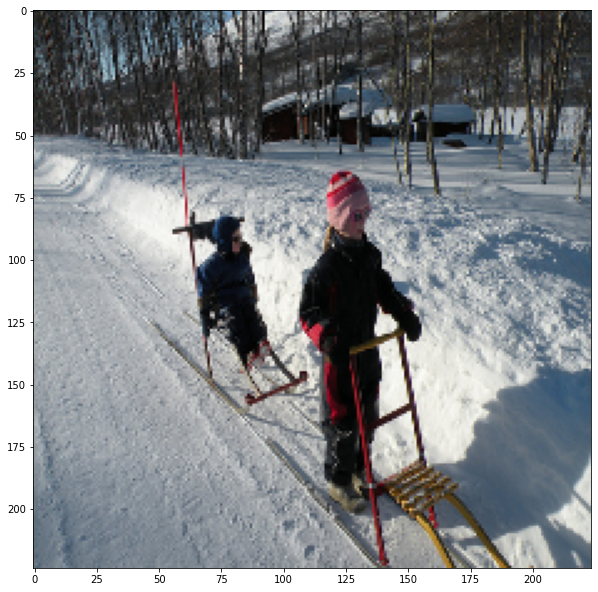

In [ ]:
plt.figure(figsize=(10,12))
plt.imshow(allImages[2003])

#  Features Exteraction  From Images 

---



In [ ]:
#start  extracvt feature function
#strat to delete latest layer of vggmodel beacuse we dident use classification model just we use 
# model to get feature exteration
#in this step we will reshape and resize model and convert all images to array to deal with model

In [ ]:
def exteract_feature(directory):
    #strat  call ing VGG model 
    model = VGG16()
    #delete lataest layer
    #model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    print(model.summary())
	# summarize
    #load image
    exteractedFeatures = dict()
    #start image preproccessing and handle all image data 
    for file in os.listdir(directory) :
            image = cv2.imread(os.path.join(directory,file))
            image = cv2.resize(image,(224,224))
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            image = np.asarray(image)
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            image_id = file.split('.')[0]
            # store feature
            exteractedFeatures[image_id]=feature
            print('>%s' % file)
    return exteractedFeatures        

# extract features from all images
directory = '/content/drive/MyDrive/datasets/archive.zip (Unzipped Files)/Flickr8k_Dataset/Flicker8k_Dataset'
features = exteract_feature(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('/content/drive/MyDrive/model_result/image_caption_features.pkl', 'wb'))
#/content/drive/MyDrive/datasets/archive (1).zip (Unzipped Files)/Images
#exteract_feature('/content/drive/MyDrive/datasets/archive (1).zip (Unzipped Files)/Images')

Streaming output truncated to the last 5000 lines.
>3138433655_ea1d59e5b7.jpg
>3138562460_44227a35cf.jpg
>3138504165_c7ae396294.jpg
>3138746531_f6b816c126.jpg
>3139118874_599b30b116.jpg
>3139238055_2817a0c7d8.jpg
>3139160252_75109e9e05.jpg
>3139389284_f01bd4c236.jpg
>3139393607_f0a54ca46d.jpg
>3139837262_fe5ee7ccd9.jpg
>3139876823_859c7d7c23.jpg
>3139895886_5a6d495b13.jpg
>3141293960_74459f0a24.jpg
>3141440149_00becbbb93.jpg
>3141613533_595723208d.jpg
>3142055158_01b9e4caa4.jpg
>3143155555_32b6d24f34.jpg
>3143159297_6f2f663ea6.jpg
>3143574389_8a4048fbe2.jpg
>3143765063_a7761b16d3.jpg
>3143953179_1c08c023a5.jpg
>3143978284_ac086be9a3.jpg
>3143980056_7a64a94b58.jpg
>3143982558_9e2d44c155.jpg
>3143991972_7193381aeb.jpg
>3144705706_391d7b77c7.jpg
>3145869775_85dfae43bd.jpg
>3145967019_1a83ebf712.jpg
>3145967309_b33abe4d84.jpg
>314603661_51e05e0e24.jpg
>3146232740_df3da0163b.jpg
>3146630574_05d9ebbed1.jpg
>3146355833_1b7fc80210.jpg
>314685044_da4390728e.jpg
>3146937399_8c046b7b1a.jpg
>31472

# handling image desription 

In [ ]:
#in this step we wiil handle ll caption inside file  and make text preprocessing for images
#start reading file 
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [ ]:
#in this part we will link each image with all available caption
#we need to splite line by line then splite each line in two parts one for image id and decsription odf reach photo
#we need to add all of description to each image id 
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping


In [ ]:
#in this function we will clean all image description  form puncituation and so in 
#this function tack output from load decription function and make texte pree processing
def clean_descriptions(descriptions):
    #remove puncituation
    table = str.maketrans('','',string.punctuation)
    for key,desc_list in descriptions.items() :
        #this  for looping to get all caption which added before with image_id in previous function
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [ word.lower() for word in desc ]
            desc = [ w.translate(table)  for w in desc ]
            desc = [ word for word in desc if len(word) >1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] = ' '.join(desc)



In [ ]:
#in this function we need to collect all words to get all unique words 
#we use set in side it to prevent duplicate words
def to_vocabulary(descriptions):
    all_desc = set()
    for key in descriptions.keys():
         [all_desc.update(words.split()) for words in descriptions[key]]
    return all_desc     


In [ ]:
# in this function we will save description i new file
def save_descriptions(descriptions, filename):
	lines = []
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()


filename = '/content/drive/MyDrive/datasets/archive.zip (Unzipped Files)/Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, '/content/drive/MyDrive/model_result/descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


# Train Data 
The main task of this part is to extract features and description of tranied images .

1.we make function  to collect all image id from traind image file  in function called  load_set which return image id

2. we need to extract all caption of image id returned from  preavious function load_clean_descriptions  that check in image id if exist on main handeld text befor and check if image id exist make new start and end for caption for process of link caption with image in this 
3.   we need to function called load_photo_features which link all features of fpto from pikile file saved before  which return all feature for each photo indevidual





In [ ]:
from pickle import load

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


In [ ]:

def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

In [ ]:
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions


In [ ]:

def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

In [ ]:
# load training dataset (6K)
filename = '/content/drive/MyDrive/datasets/archive.zip (Unzipped Files)/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
#print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/model_result/descriptions.txt', train)
#print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('/content/drive/MyDrive/model_result/image_caption_features.pkl', train)
#print('Photos: train=%d' % len(train_features))
train_descriptions

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tricolored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow endse

In [ ]:
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [ ]:
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)


In [ ]:
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

In [ ]:
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

In [ ]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

#  Data Tokinizing 







In [ ]:
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [ ]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


In [ ]:
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

In [ ]:
def create_sequences(tokenizer, max_length, desc_list, photo):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)

In [ ]:
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	return model

In [ ]:
#Below code is used to progressively load the batch of data
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
			yield [[in_img, in_seq], out_word]

In [ ]:
# load training dataset (6K)
filename = '/content/drive/MyDrive/datasets/archive.zip (Unzipped Files)/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/model_result/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('/content/drive/MyDrive/model_result/image_caption_features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34


In [ ]:
# train the model
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
	# fit for one epoch
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model.save('/content/drive/MyDrive/model_result/model_' + str(i) + '.h5')


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      1940224     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


6000/6000 [==============================] - 453s 75ms/step - loss: 4.6790


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


6000/6000 [==============================] - 470s 78ms/step - loss: 3.0802


# model evaluation

In [ ]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)


In [ ]:
# map an integer to a word
#in this function we need to check if predective word is in trainde descrtption or not
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [ ]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text


In [ ]:


def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# prepare training set

# load training dataset (6K)
filename = '/content/drive/MyDrive/datasets/archive.zip (Unzipped Files)/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/model_result/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# prepare test set

# load test set
filename = '/content/drive/MyDrive/datasets/archive.zip (Unzipped Files)/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('/content/drive/MyDrive/model_result/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('/content/drive/MyDrive/model_result/image_caption_features.pkl', test)
print('Photos: test=%d' % len(test_features))

# load the model which has minimum loss, in this case it was model_18
filename = '/content/drive/MyDrive/model_result/model_18.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.519718
BLEU-2: 0.277866
BLEU-3: 0.188324
BLEU-4: 0.087255


In [ ]:

from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model

# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# load the tokenizer
tokenizer = load(open('/content/drive/MyDrive/model_result/tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('/content/drive/MyDrive/model_result/model_18.h5')
# load and prepare the photograph
photo = extract_features('/content/drive/MyDrive/download.jfif')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq boy in red swimsuit is jumping into pool endseq


In [ ]:
#Remove startseq and endseq
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)

print(result)

boy in red swimsuit is jumping into pool
